# New york city airbnb open data

The [data documentation](https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data) does not provide much information about the dataset.

In [1]:
import pandas as pd
import seaborn as sns
import os
from data import load_dataset
import plotter

/Users/aru/code/data-smells/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preliminary analysis

In [3]:
airbnb = load_dataset("airbnb")
airbnb

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


We have a mix of text, numerical and categorical features, let's take a closer look at the features.

In [4]:
airbnb.shape

(48895, 16)

In [5]:
airbnb.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

### Handling redundant columns

So far, we have been dropping columns such as `id` & `host_id` since they contain unique identifiers which does not bring any new information to the model to learn. However, I did not consider the case where we may have data from the same entity (in this example the host, who may have multiple properties to rent out). Perhaps, there is a correlation between the number of properties and the other numerical features? Let's investigate.

In [6]:
identifier_columns = ["id", "host_id"]
identifiers = airbnb[identifier_columns]
identifiers[identifiers.duplicated(keep=False)]

,id,host_id


We don't have any "trully" duplicate examples (same listing with the same host). But we still may have different listings from the same host or same listing from different hosts (which would be incorrect/outlier)! Let's example them separately next.

In [7]:
identifiers.loc[:, "dup_id"] = identifiers.duplicated("id", keep=False)
identifiers.loc[:, "dup_host_id"] = identifiers.duplicated("host_id", keep=False)
identifiers

/var/folders/72/dkwg1j016fqf0st2qg2_56740000gn/T/ipykernel_37400/2750994099.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identifiers.loc[:, "dup_id"] = identifiers.duplicated("id", keep=False)
/var/folders/72/dkwg1j016fqf0st2qg2_56740000gn/T/ipykernel_37400/2750994099.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  identifiers.loc[:, "dup_host_id"] = identifiers.duplicated("host_id", keep=False)


,id,host_id,dup_id,dup_host_id
0,2539,2787,False,True
1,2595,2845,False,True
2,3647,4632,False,False
3,3831,4869,False,False
4,5022,7192,False,False
...,...,...,...,...
48890,36484665,8232441,False,True
48891,36485057,6570630,False,True
48892,36485431,23492952,False,False
48893,36485609,30985759,False,True


In [8]:
identifiers["dup_id"].any()

np.False_

In [9]:
identifiers["dup_host_id"].any()

np.True_

We don't have any duplicate id which means that we do not have a listing with multiple hosts (this is good), but we do have hosts with multiple listings (this is normal). Perhaps a useful feature to extract would be the number of listings for all hosts, but this is beyond the scope of this analysis. For now, we drop the identifier columns.

In [10]:
airbnb = airbnb.drop(identifier_columns, axis="columns")
airbnb.shape

(48895, 14)

### Handling text features

The `name` feature may contain several interesting numerical features (for instance, we can do an analysis of the most common words and if they are positively correlated with the number of reviews). For this analysis however, we drop it.

In [11]:
airbnb = airbnb.drop("name", axis="columns")
airbnb.shape

(48895, 13)

The `host_name` feature is worth investigating. For instance, what is the most common name? And is there any relationship between the common names and the number of reviews their listing(s) get?

In [18]:
airbnb["host_name"] = airbnb["host_name"].str.strip().astype("category")
airbnb["host_name"].cat.categories

Index([''Cil', '(Ari) HENRY LEE', '(Email hidden by Airbnb)', '(Mary) Haiy',
       '-TheQueensCornerLot', '0123', '2018Serenity', '371', '475',
       '5 Star Stays',
       ...
       '辣辣', '铀 Yuli', '青明', '韦达', '馨惠', '단비', '빈나', '소정', '진', '현선'],
      dtype='object', length=11452)

In [19]:
airbnb["host_name"].value_counts()

host_name
Michael         417
David           403
Sonder (NYC)    327
John            294
Alex            279
               ... 
Jerbean           1
Jerald            1
Jeonghoon         1
Jeny              1
현선                1
Name: count, Length: 11452, dtype: int64

Popular names are what we would expect (for a North American country). It does look like we have to perform some processing as there are names with special characters and mixed languages.

### Handling categorical features

`neighbourhood_group`, `neighbourhood` and `room_type` are categorical, let's convert them to `category` dtype.

In [25]:
categorical_features = [
    "neighbourhood_group",
    "neighbourhood",
    "room_type"
]

airbnb[categorical_features] = airbnb[categorical_features].apply(
    lambda col: col.str.strip().astype("category")
)

In [26]:
airbnb["neighbourhood_group"].value_counts()

neighbourhood_group
Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64

In [27]:
airbnb["neighbourhood"].value_counts()

neighbourhood
Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
                      ... 
Richmondtown             1
Willowbrook              1
Fort Wadsworth           1
New Dorp                 1
Woodrow                  1
Name: count, Length: 221, dtype: int64

In [28]:
airbnb["room_type"].value_counts()

room_type
Entire home/apt    25409
Private room       22326
Shared room         1160
Name: count, dtype: int64

### Handling datetime features

`last_review` should be converted to `datetime` dtype.

In [29]:
airbnb["last_review"] = pd.to_datetime(airbnb["last_review"])
airbnb["last_review"]

0       2018-10-19
1       2019-05-21
2              NaT
3       2019-07-05
4       2018-11-19
           ...    
48890          NaT
48891          NaT
48892          NaT
48893          NaT
48894          NaT
Name: last_review, Length: 48895, dtype: datetime64[ns]

### Handling numerical features

The docs specify that the price is in USD.

The `calculated_host_listings_count` is the number of listings the host has (what we also suggested earlier).

### Descriptive statistics, missing & duplicates

In [30]:
airbnb.describe(include="all")

,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
count,48874,48895,48895,48895.000000,48895.000000,48895,48895.000000,48895.000000,48895.000000,38843,38843.000000,48895.000000,48895.000000
unique,11452,5,221,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Michael,Manhattan,Williamsburg,NaN,NaN,Entire home/apt,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,417,21661,3920,NaN,NaN,25409,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,40.728949,-73.952170,NaN,152.720687,7.029962,23.274466,2018-10-04 01:47:23.910099456,1.373221,7.143982,112.781327
min,NaN,NaN,NaN,40.499790,-74.244420,NaN,0.000000,1.000000,0.000000,2011-03-28 00:00:00,0.010000,1.000000,0.000000
25%,NaN,NaN,NaN,40.690100,-73.983070,NaN,69.000000,1.000000,1.000000,2018-07-08 00:00:00,0.190000,1.000000,0.000000
50%,NaN,NaN,NaN,40.723070,-73.955680,NaN,106.000000,3.000000,5.000000,2019-05-19 00:00:00,0.720000,1.000000,45.000000
75%,NaN,NaN,NaN,40.763115,-73.936275,NaN,175.000000,5.000000,24.000000,2019-06-23 00:00:00,2.020000,2.000000,227.000000
max,NaN,NaN,NaN,40.913060,-73.712990,NaN,10000.000000,1250.000000,629.000000,2019-07-08 00:00:00,58.500000,327.000000,365.000000


Check for missing values next.

In [31]:
airbnb.isna().any()

host_name                          True
neighbourhood_group               False
neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
last_review                        True
reviews_per_month                  True
calculated_host_listings_count    False
availability_365                  False
dtype: bool

How much data is missing in total and per column?

In [32]:
airbnb[airbnb.isna().any(axis="columns")]

,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
2,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaT,NaN,1,365
19,Sing,Manhattan,East Harlem,40.79685,-73.94872,Entire home/apt,190,7,0,NaT,NaN,2,249
26,Claude & Sophie,Manhattan,Inwood,40.86754,-73.92639,Private room,80,4,0,NaT,NaN,1,0
36,Vt,Brooklyn,Bedford-Stuyvesant,40.68876,-73.94312,Private room,35,60,0,NaT,NaN,1,365
38,Harriet,Brooklyn,Flatbush,40.63702,-73.96327,Private room,150,1,0,NaT,NaN,1,365
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaT,NaN,2,9
48891,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaT,NaN,2,36
48892,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaT,NaN,1,27
48893,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaT,NaN,6,2


In [33]:
airbnb[airbnb["host_name"].isna()].shape

(21, 13)

In [34]:
airbnb[airbnb["last_review"].isna()].shape

(10052, 13)

In [35]:
airbnb[airbnb["reviews_per_month"].isna()].shape

(10052, 13)

Most of the missing data is in the `last_review` and `reviews_per_month` features. We may wish to drop these two columns, as imputing will lead to technical debt.

Finally, Checking for duplicates.

In [36]:
airbnb[airbnb.duplicated()].shape

(0, 13)

### Correlations

Check the correlations between the numerical features.

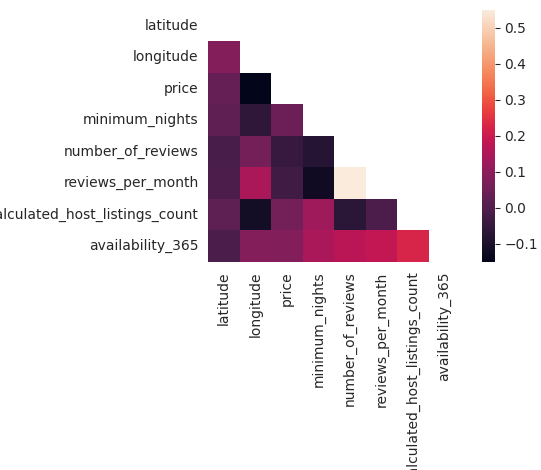

In [37]:
plotter.corr(airbnb.corr(numeric_only=True))

No significant positive correlations except for `reviews_per_month` and `number_of_reviews` which is to be expected.